# Imports and setup

In [1]:
# import of necessary libraries
import numpy as np
import pandas as pd
import plotly.express as px

## Functions

In [2]:
def get_fft(data, feature="acc_x", timespan=(0, np.Inf)):
    """
    Calculates the Fast Fourier Transformation of the given data.
    Returns the frequency spectrum and the plot.

    Parameters
    ----------
    data : pandas.DataFrame
        Dataframe containing the data.
    axis : str
        Axis to calculate the FFT for.
    timespan : tuple
        Tuple containing the start and end time of the timespan (in seconds) to calculate the FFT for.
    """

    # split data with given timespan
    start = timespan[0]
    end = timespan[1]
    data = data[(data["time"] >= start) & (data["time"] <= end)]

    # fft of all axis
    fft = np.fft.fft(data[feature])

    # get frequencies
    freq = np.fft.fftfreq(data.shape[0])

    # get absolute values
    fft = np.abs(fft)

    # remove negative frequencies
    fft = fft[freq >= 0]
    freq = freq[freq >= 0]

    # plot frequency spectrum
    fig = px.line(x=freq, y=fft)

    # set labels
    fig.update_layout(
        title=f"Fast Fourier Transformation of {feature} Feature between {start}s and {end}s",
        xaxis_title="Frequency",
        yaxis_title="Amplitude",
    )

    # return fft values, frequencies and figure
    return fft, freq, fig


# Import data

In [3]:
# import data
data = pd.read_csv("data_sensor_2022.csv", usecols=range(1, 19))

# Wrangle Data

In [4]:
# convert time to datetime
data["time"] = pd.to_datetime(data["time"])

# sort data by time
data = data.sort_values(by=["name", "activity", "time"])
data = data.reset_index(drop=True)

# get time delta as ms
data["time_delta_ms"] = data["time"].diff().dt.total_seconds() * 1000
data["time_delta_ms"] = data["time_delta_ms"].fillna(0)

# split data into observations based on time delta > 10s
data["new_obs"] = np.where((data["time_delta_ms"] > 10000), 1, 0)
# where same observation, but different activity, split into new observation
data["new_obs"] = np.where(
    (data["new_obs"] == data["new_obs"].shift(1))
    & (data["activity"] != data["activity"].shift(1)),
    1,
    data["new_obs"],
)
# where same observation, but different name, split into new observation
data["new_obs"] = np.where(
    (data["new_obs"] == data["new_obs"].shift(1))
    & (data["name"] != data["name"].shift(1)),
    1,
    data["new_obs"],
)
# set observation id
data["Observation_ID"] = data["new_obs"].cumsum()

# remove time delta and new obs columns
data = data.drop(columns=["time_delta_ms", "new_obs"])

# reset time to start at -10 for each observation and convert to s
data["time"] = data.groupby("Observation_ID")["time"].transform(lambda x: x - x.min())
data["time"] = data["time"].dt.total_seconds()

# drop name
data = data.drop(columns=["name"])

data

,time,activity,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,gyr_x,gyr_y,gyr_z,ori_x,ori_y,ori_z,ori_w,lat,long,Observation_ID
0,0.000,Bicycling,-0.207695,0.435086,0.950025,-12.881250,-19.85625,-47.17500,-0.640321,-0.468520,-0.191043,0.153597,-0.126724,-0.827343,0.525216,47.481336,8.210079,0
1,0.195,Bicycling,-0.082749,0.248399,0.915145,15.037500,-52.06875,-30.58125,-0.710110,-1.316987,1.615233,0.066866,0.045946,0.178426,0.979593,47.481336,8.210079,0
2,0.252,Bicycling,-0.020519,0.315628,0.759556,8.053125,-50.25000,-30.71250,1.625923,-0.941926,-0.245408,0.123269,0.028758,0.218891,0.967114,47.481336,8.210079,0
3,0.309,Bicycling,-0.047228,0.243398,0.986643,5.212500,-52.18125,-26.88750,0.158057,0.412322,0.069178,0.162438,0.019713,0.210182,0.963575,47.481336,8.210079,0
4,0.393,Bicycling,-0.062839,0.319287,0.976642,5.006250,-51.71250,-25.83750,-0.361774,0.089184,-0.106135,0.171021,0.026682,0.238865,0.955407,47.481336,8.210079,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825264,536.655,Walking,-0.095966,0.348618,0.916242,28.687500,-25.91250,-25.35000,0.382543,1.597213,-0.107891,0.067436,0.373432,0.597652,0.706291,47.279000,8.393493,447
1825265,536.706,Walking,-0.322305,0.326513,0.600828,29.512500,-26.58750,-23.28750,-0.082388,1.721826,-0.073683,0.069805,0.372018,0.604714,0.700734,47.279000,8.393493,447
1825266,536.756,Walking,-0.366729,0.458807,0.611072,30.956250,-27.00000,-20.85000,-0.261977,0.443933,0.080861,0.074125,0.355670,0.590916,0.720294,47.279000,8.393493,447
1825267,536.807,Walking,-0.358436,0.437068,0.778978,31.687500,-27.05625,-20.38125,-0.303820,-0.092696,-0.021151,0.073810,0.355730,0.588875,0.720772,47.279000,8.393493,447


In [5]:
# cut off first and last 10s
data = data[(data["time"] > 10) & (data["time"] < data["time"].max() - 10)]

# remove all observations with less than 10s
data = data.groupby("Observation_ID").filter(lambda x: x["time"].max() > 10)

# remove all observations with timedeltas of over 1s
data = data.groupby("Observation_ID").filter(lambda x: x["time"].diff().max() < 2)

# replace id with new cumsum
data["Observation_ID"] = np.where(data["Observation_ID"] != data["Observation_ID"].shift(1), 1, 0).cumsum() - 1
data = data.set_index("Observation_ID")

# reset time to start at 0
data["time"] = data.groupby("Observation_ID")["time"].transform(lambda x: x - x.min())

data

,time,activity,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,gyr_x,gyr_y,gyr_z,ori_x,ori_y,ori_z,ori_w,lat,long
Observation_ID,,,,,,,,,,,,,,,,,
0,0.000,Bicycling,0.212787,-0.909352,-0.659703,19.91250,14.30625,54.95625,-0.147978,-0.524107,-0.734086,-0.832350,-0.350811,0.113831,0.414281,47.481336,8.210086
0,0.101,Bicycling,0.196932,-0.883863,-0.569515,19.56562,13.22813,54.45000,-0.342227,-0.442253,-0.767072,-0.820477,-0.388824,0.115505,0.402837,47.481336,8.210086
0,0.215,Bicycling,0.321147,-0.893741,-0.814910,19.36875,11.16562,54.30000,-0.901305,-0.432480,-0.708430,-0.812220,-0.421646,0.112435,0.386518,47.481336,8.210086
0,0.334,Bicycling,0.353252,-0.562075,-0.730104,19.21875,7.38750,54.04688,-1.171911,-0.823422,-0.521511,-0.812344,-0.465150,0.094680,0.336037,47.481336,8.210086
0,0.999,Bicycling,0.145435,-0.316329,-0.850172,21.66563,-8.56875,51.22500,-0.583512,0.058030,-0.800668,-0.856575,-0.457427,0.005205,0.200705,47.481327,8.210081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,526.644,Walking,-0.095966,0.348618,0.916242,28.68750,-25.91250,-25.35000,0.382543,1.597213,-0.107891,0.067436,0.373432,0.597652,0.706291,47.279000,8.393493
244,526.695,Walking,-0.322305,0.326513,0.600828,29.51250,-26.58750,-23.28750,-0.082388,1.721826,-0.073683,0.069805,0.372018,0.604714,0.700734,47.279000,8.393493
244,526.745,Walking,-0.366729,0.458807,0.611072,30.95625,-27.00000,-20.85000,-0.261977,0.443933,0.080861,0.074125,0.355670,0.590916,0.720294,47.279000,8.393493


# First Insights

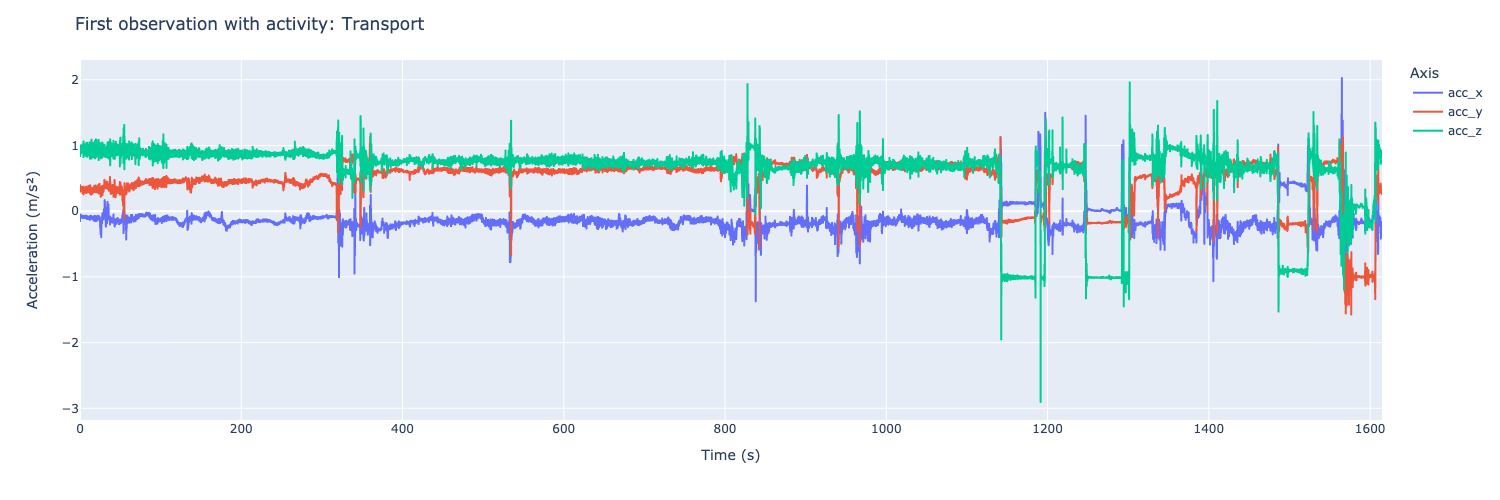

In [6]:
# visualize first observation acc_x , acc_y , acc_z
fig = px.line(data.loc[23], x="time", y=["acc_x", "acc_y", "acc_z"])

fig.update_layout(
    title=f"First observation with activity: {data.loc[23]['activity'].iloc[0]}",
    xaxis_title="Time (s)",
    yaxis_title="Acceleration (m/s²)",
    legend_title="Axis",
)

fig.show("png", width=1500)


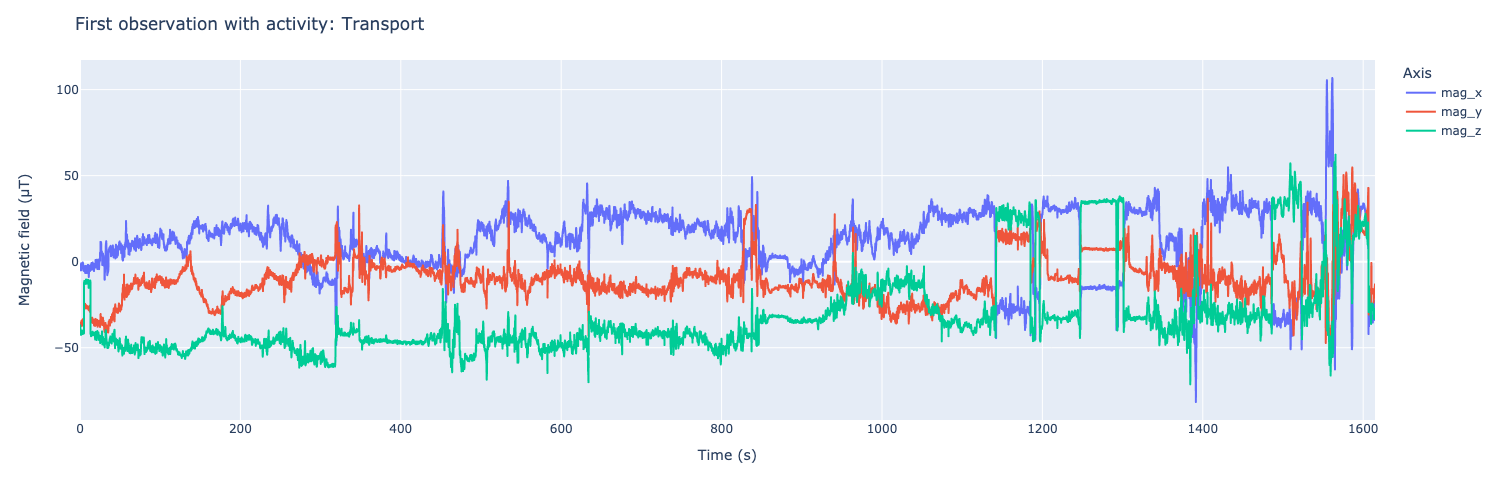

In [7]:
# plot first observation mag_x , mag_y , mag_z
fig = px.line(data.loc[23], x="time", y=["mag_x", "mag_y", "mag_z"])

fig.update_layout(
    title=f"First observation with activity: {data.loc[23]['activity'].iloc[0]}",
    xaxis_title="Time (s)",
    yaxis_title="Magnetic field (μT)",
    legend_title="Axis",
)

fig.show("png", width=1500)

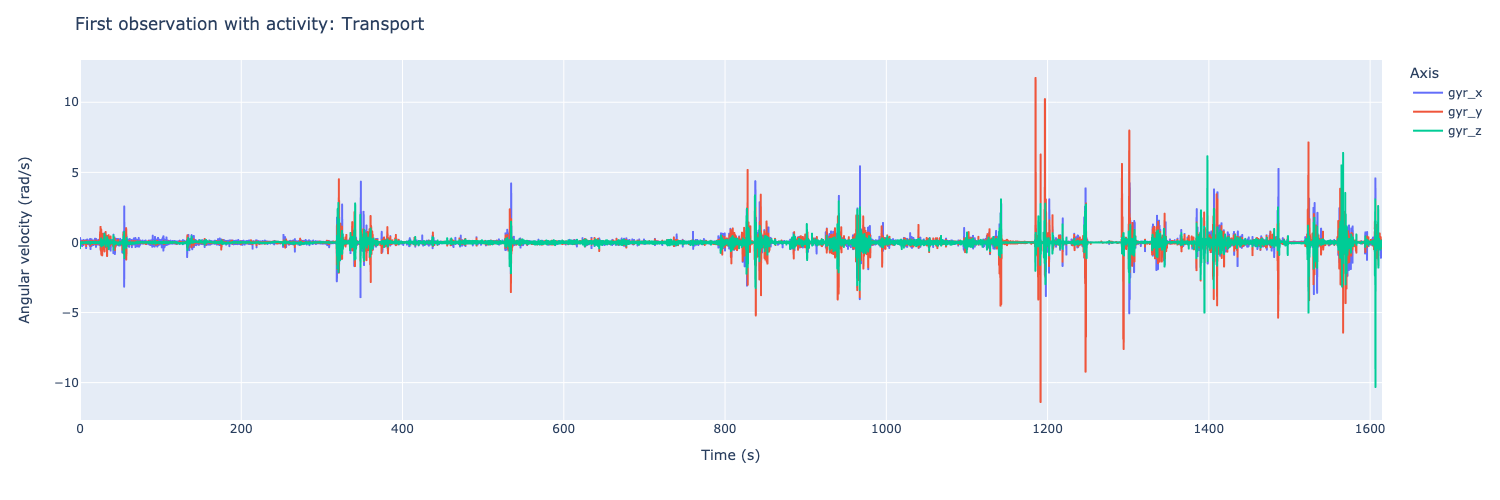

In [8]:
# plot random observation gyr_x , gyr_y , gyr_z
fig = px.line(data.loc[23], x="time", y=["gyr_x", "gyr_y", "gyr_z"])

fig.update_layout(
    title=f"First observation with activity: {data.loc[23]['activity'].iloc[0]}",
    xaxis_title="Time (s)",
    yaxis_title="Angular velocity (rad/s)",
    legend_title="Axis",
)

fig.show("png", width=1500)

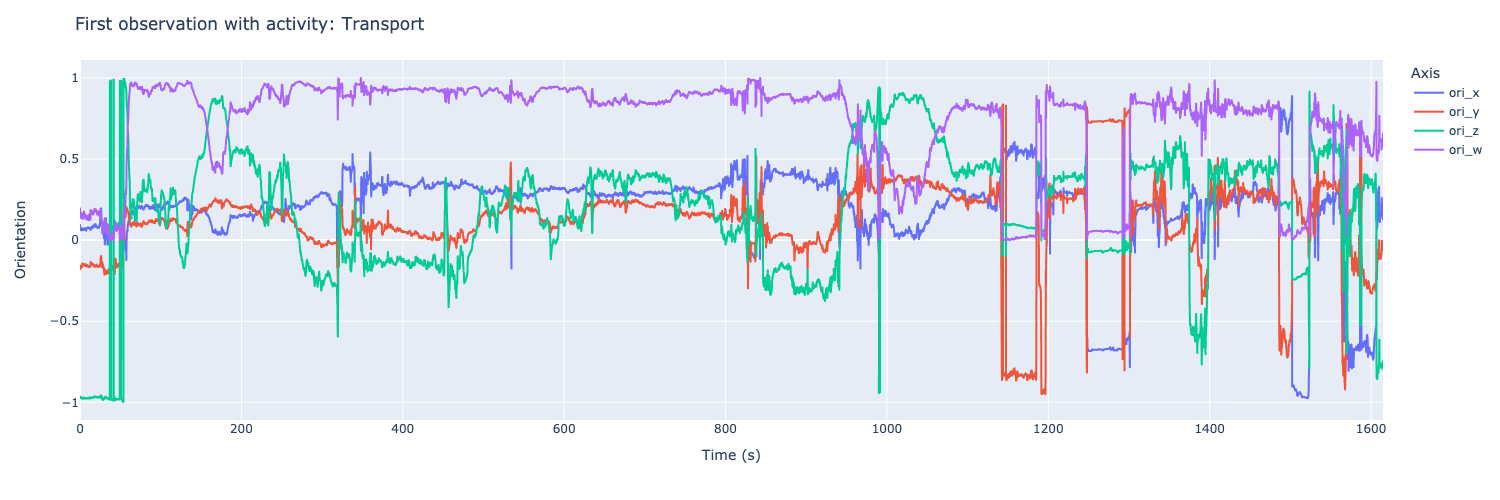

In [9]:
# plot first observation ori_x , ori_y , ori_z, ori_w
fig = px.line(data.loc[23], x="time", y=["ori_x", "ori_y", "ori_z", "ori_w"])

fig.update_layout(
    title=f"First observation with activity: {data.loc[23]['activity'].iloc[0]}",
    xaxis_title="Time (s)",
    yaxis_title="Orientation",
    legend_title="Axis",
)

fig.show("png", width=1500)

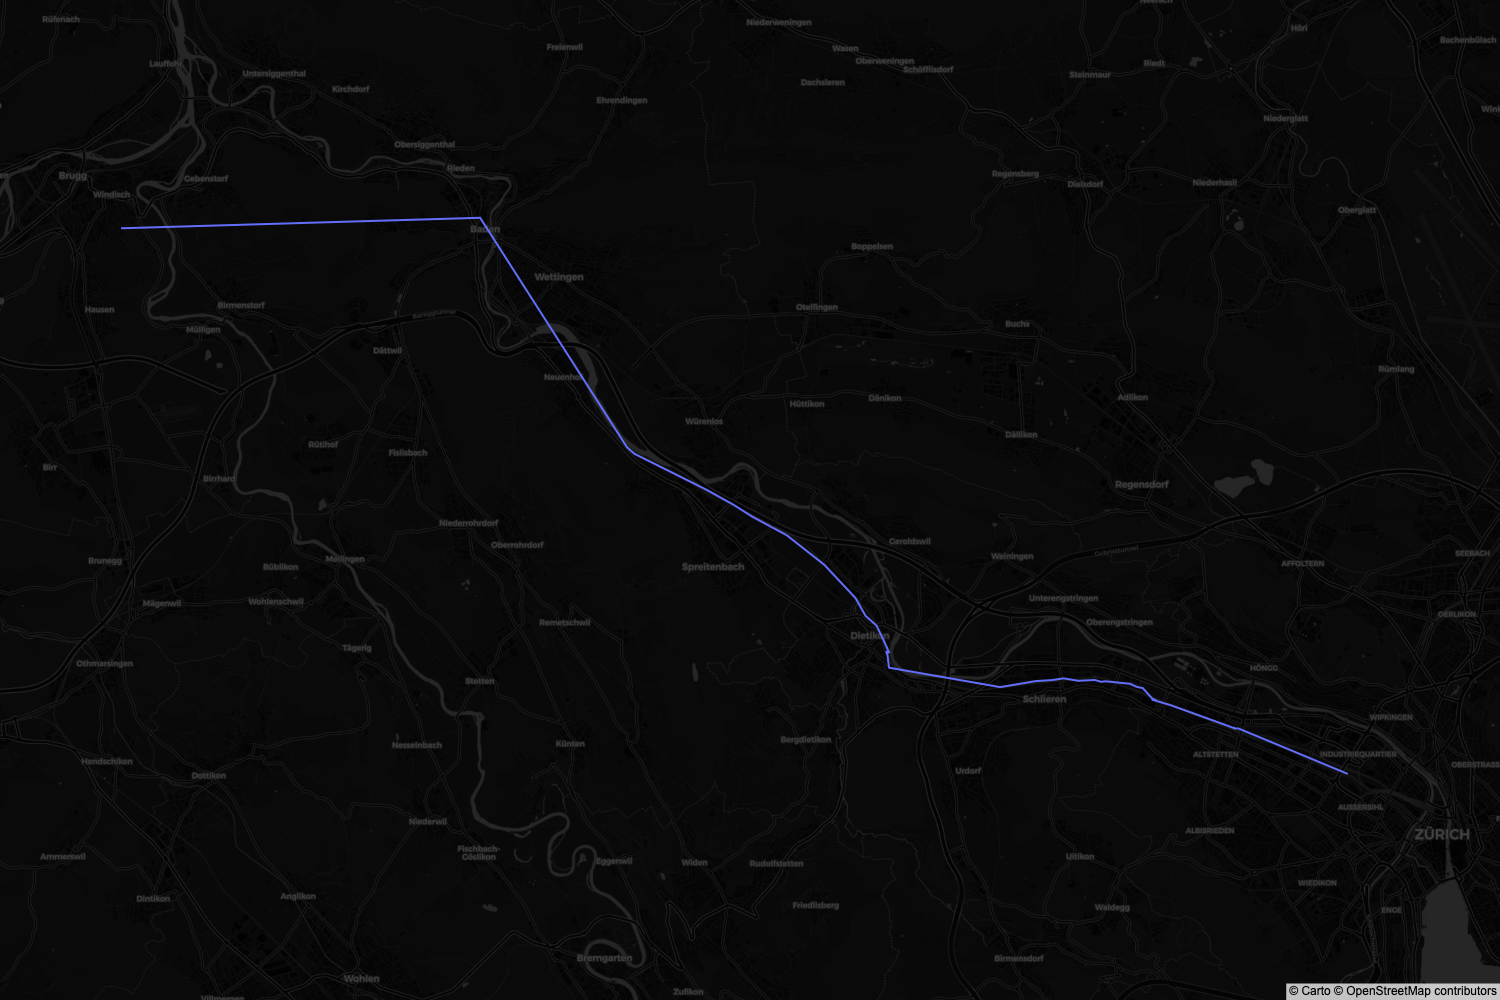

In [10]:
# plot first observation lat, long as map
fig = px.line_mapbox(data.loc[23], lat="lat", lon="long", zoom=11.5, height=1000)

fig.update_layout(
    mapbox_style="carto-darkmatter",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
)

fig.show("png", width=1500)

# Fourier Transformation

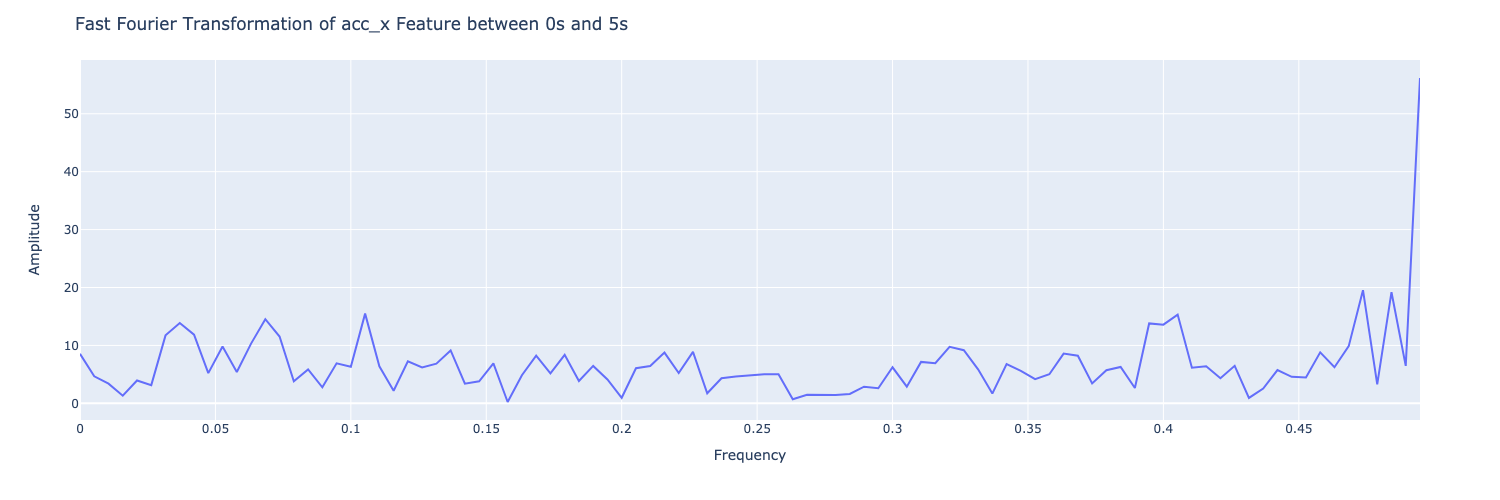

In [11]:
_, _, fig = get_fft(data.loc[4], "acc_x", (0, 5))
fig.show("png", width=1500)

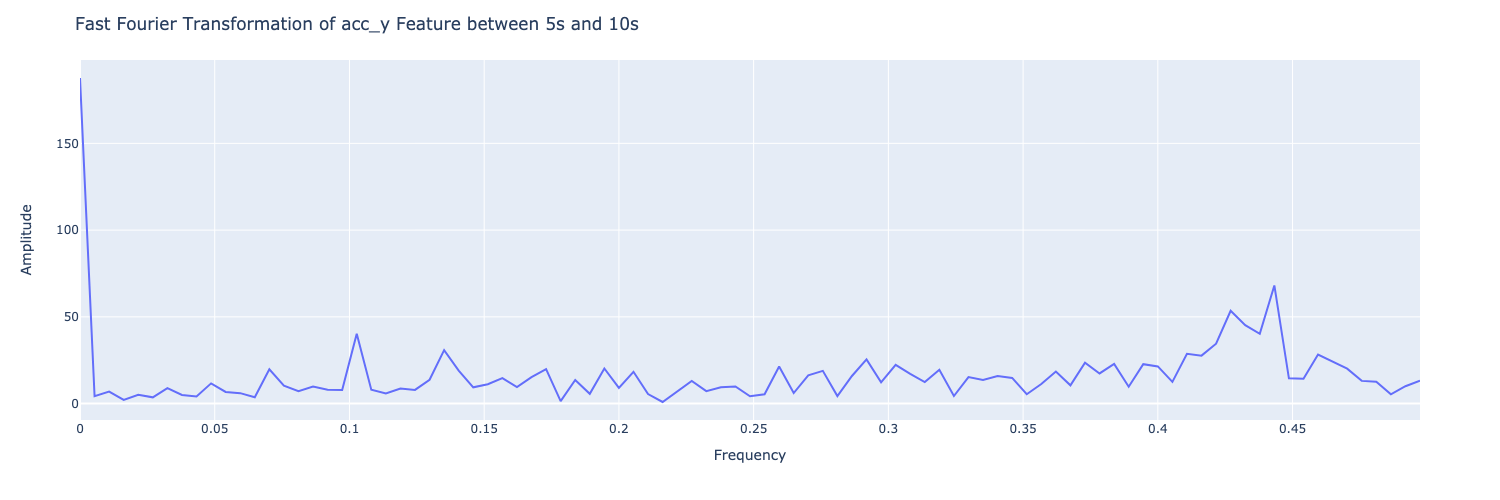

In [12]:
_, _, fig = get_fft(data.loc[4], "acc_y", (5, 10))
fig.show("png", width=1500)